# Mini Generative Pretrained Transformer-1 (mGPT-1)

This notebook illustrates a basic implementation of the Generative Pretrained Transformer model using PyTorch. We follow a similar approach as described in the original [GPT-1 paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). Further details about the model architecture will be provided in the Mini GPT Architecture section. The specific sections covered in this notebook are:

1. Data Downloading and Normalization
2. Training Custom Tokenizer
3. Building Custom Dataset and Data Loader
4. Mini GPT Architecture

**Introduction**

One of the most well-known successes of transformer-based language models has been text generation with the GPT-2, GPT-3, and GPT-4 language models, which are built from stacks of transformer-decoder layers. GPT (Generative Pre-training) is a family of generative pre-training models that are part of the language modeling trend where a model is first trained on unsupervised data, in a task-agnostic fashion, and later fine-tuned for a specific task. The first model in this family, the eponymous [GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), pre-trains a stack of transformer decoder layers on a large body of unlabeled text and is then fine-tuned on labeled, task-specific data. GPT is an autoregressive model, which means it uses inputs from previous steps of a sequence to predict values later in the sequence.

Different from the original implementation of the first [GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), here we will not fine-tune the model on a downstream task; we will focus only on the unsupervised pre-training phase. Another important change is that we will use the [Byte-Pair Encoding Tokenizer](https://github.com/omarcastano/solo-learning-nlp/blob/main/self-supervised/Byte_Pair_Encoding_tokenization.ipynb) instead of the SpaCy tokenizer as done in the original paper.


**Unsupervised pre-training**: In this phase, **GPT** starts with a corpus of tokens and, moving through it, learns how to predict the next token, given some preceding context. More formally, given an unlabeled corpus of tokens $X = \{x_1, \ldots, x_n\}$, the model learns the conditional probability of predicting token $x_t$ given the preceding $k$ tokens $P(x_t | x_{t-1}, \ldots, x_{t-k})$ by minimizing the negative log-likelihood

$$L(X) = -\sum_t \log P(x_t | x_{t-1}, \ldots, x_{t-k}; \Theta)$$


the conditional probability $P$ is modeled using a neural network with $\Theta$ represents the model parameters.

The neural network model applies a multi-headed self-attention operation over the input context tokens followed by position-wise feedforward layers to produce an output distribution over target tokens:



<div style="text-align: center;">
    <img src="https://i.imgur.com/dMO2Dtq.png" alt="" width="800px" height="500px">
</div>

Where $W_e$ and $W_p$ are the token and positional embedding matrices respectively. $W_f$ is a projection matrix to get the logits. `<s>` denotes the beginning of sentence token and `</s>` denotes the end of sentence token.



In [1]:
# black formatting with jupyter-black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=140,
)

## Data Preparation

We will use the [Wikipedia dataset](https://huggingface.co/datasets/bookcorpus/bookcorpus) to pre-train our Mini GPT model. This dataset is approximately 20GB in size, so please grab a coffee while the data is being downloaded.


In [2]:
# import load_dataset
from datasets import load_dataset

We will not be using the entire dataset due to the extended training time it would require. Instead, we will work with a smaller portion of the original dataset. Feel free to adjust the amount of data used for training.


In [3]:
# load de dataset
data = load_dataset("wikipedia", "20220301.en", split="train[0:500]", trust_remote_code=True).to_pandas()
# data = load_dataset("karpathy/tiny_shakespeare", split="train", trust_remote_code=True).to_pandas()

Next, we define a basic data pre-processing function that handles text normalization.

In [4]:
import re
import string


# Basic preprocessing.
def text_preprocessing(text: str) -> str:

    # to lower
    text = text.lower()

    # remove number
    text = re.sub(r"\d+", "", text)

    # remove html tags
    text = re.sub(r"<.*?>", "", text)

    # remove urls
    text = re.sub(r"https?://\S+", "", text)

    # remove white spaces at the start and the end
    text = text.strip()

    return text

In [5]:
# apply text normalization
data.text = data.text.apply(text_preprocessing)
data.head()

,id,url,title,text
0,12,https://en.wikipedia.org/wiki/Anarchism,Anarchism,anarchism is a political philosophy and moveme...
1,25,https://en.wikipedia.org/wiki/Autism,Autism,autism is a neurodevelopmental disorder charac...
2,39,https://en.wikipedia.org/wiki/Albedo,Albedo,albedo (; ) is the measure of the diffuse refl...
3,290,https://en.wikipedia.org/wiki/A,A,"a, or a, is the first letter and the first vow..."
4,303,https://en.wikipedia.org/wiki/Alabama,Alabama,alabama () is a state in the southeastern regi...


## Training Custom Tokenizer 

In previous notebooks, we have implemented a [Byte-Pair Encoding Tokenizer](https://github.com/omarcastano/solo-learning-nlp/blob/main/self-supervised/Byte_Pair_Encoding_tokenization.ipynb) using only NumPy. However, this Python implementation is quite slow, so we will use the Transformers implementation of the Byte-Pair Encoding Tokenizer to save some time.


In [6]:
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import ByteLevel
import pandas as pd
from tokenizers import decoders

We will use the following special tokens:

- `<unk>`: Unknown token
- `<s>`: Start of sentence token
- `</s>`: End of sentence token

For the pre-tokenizer, we will use `ByteLevel`, which is very similar to the pre-tokenizer used in the GPT-2 tokenizer.

In [7]:
# Initialize tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))

# setting pre-tokenization to ByteLevel this is similar to gpt2 tokenizer
tokenizer.pre_tokenizer = ByteLevel()

# tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()

# Initialize a trainer with desired parameters
vocab_size = 30000
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>", "<s>", "</s>"])

# Load your training data into a list of strings
train_data = data.text.tolist()

# Train the tokenizer
tokenizer.train_from_iterator(
    train_data,
    trainer=trainer,
)

In [8]:
# quick tokenizer test
tokenizer.encode("she's buying a stairway to heaven!!").tokens

['Ġshe', "'s", 'Ġbuying', 'Ġa', 'Ġstair', 'way', 'Ġto', 'Ġheaven', '!', '!']

In [9]:
# count number of tokens per instance
data["text_length"] = data.text.apply(lambda x: len(tokenizer.encode(x).tokens))
data.text_length.describe()
data = data.query("text_length == 53")

From the statistics show above we can se that dataset is composed of wikipedia pages with different lengths, varying from 53 tokens to 25256 with a median of 6834

<Axes: xlabel='text_length', ylabel='Count'>

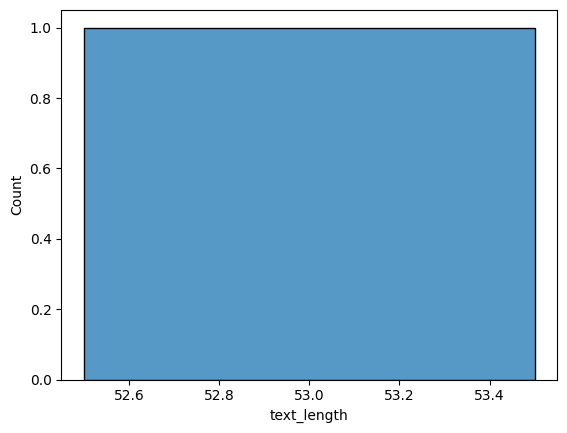

In [10]:
# plot number of words distribution#mini-gpt
import seaborn as sns

sns.histplot(data=data, x="text_length")

## Prepare Training Data For Causal Language Modeling

In order to prepare our data for causal language modeling, we need to split every Wikipedia page into segments no longer than a defined maximum sequence length (`max_seq_len`). For instance, consider a Wikipedia page with 53 tokens, and assume we set `max_seq_len=12`. This would result in dividing the page into 53//12=4 segments that can be fed into the model for training in batches. It's important to note that 53 divided by 12 equals to 4.416, but using the floor division operator (//) ensures integer division, allowing us to discard the final segment that doesn't reach 14 tokens without the need for padding tokens.

The original page containing 53 os the following:

**wikipedia_page**: ```trachysomus buquetii is a species of beetle in the family cerambycidae. it was described by james thomson in . it is known from argentina and brazil.\n\nreferences\n\nonciderini\nbeetles described in```

after splitting the wiki page into 4 segments of 12 tokens we end up with the following table of segments and tokens.

|    | text                                        | tokens                                                        |
|---:|:--------------------------------------------|:--------------------------------------------------------------|
|  0 | \<s>trachysomus buquetii is a species of\</s> | [1, 755, 226, 558, 218, 207, 815, 11019, 1103, 231, 168, 1378, 192, 2]  |
|  1 | \<s>beetle in the family cerambycidae. it was\</s>   | [1, 28906, 194, 172, 1274, 2701, 225, 1198, 33, 6433, 16, 269, 254, 2] |
|  2 | \<s>described by james thomson in . it is known from argentina and\</s> | [1, 1808, 260, 2429, 14373, 194, 351, 269, 231, 738, 307, 8602, 198, 2]  |
|  3 | \<s> brazil.\n\nreferences\n\nonciderini\n\</s>     | [1, 3959, 16, 132, 132, 1974, 132, 132, 174, 33, 764, 4105, 132, 2]    |


Notice that the las part of the sentence is compose by **beetles described in** with only three tokens **[25259, 1808, 194]** so we discard this final segment.

In [19]:
tokenizer.encode("beetles described in").ids

[25259, 1808, 194]

In [15]:
data.text.iloc[0]

'trachysomus buquetii is a species of beetle in the family cerambycidae. it was described by james thomson in . it is known from argentina and brazil.\n\nreferences\n\nonciderini\nbeetles described in'

In [17]:
53 / 12

4.416666666666667

In [ ]:
# Define max sequence length
max_seq_len = 14

split_tokens_ids = []
split_tokens = []

# In order to latter add being of sentence token (<s>) and end of sentence token (</s>), we subtract -2 to the max_seq_len
seq_len = max_seq_len - 2

# Iterate over the entire dataset and generate tokens ids
for id in range(len(data)):

    tokens = tokenizer.encode(data.text.tolist()[id]).ids

    for i in range(len(tokens) // seq_len):

        #  Adds the <s> and </s> to the sentences then encode into tokens ids and
        token_ids = tokenizer.encode("<s>").ids + tokens[i * seq_len : (i + 1) * seq_len] + tokenizer.encode("</s>").ids
        split_tokens_ids.append(token_ids)

        # decode tokens_ids
        decoded_tokens = tokenizer.decode(split_tokens_ids[i], skip_special_tokens=False)
        split_tokens.append(decoded_tokens)


# Create a pandas dataframe with the text and tokens ids
prepared_data = pd.DataFrame({"text": split_tokens, "tokens": split_tokens_ids})
print(prepared_data.shape)
prepared_data.head(10)

## Create Custom Dataset and Data Collator

Here we define our custom dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        tokens_ids = self.data.tokens.iloc[idx]
        tokens_ids = torch.LongTensor(tokens_ids)

        return tokens_ids

In [ ]:
def data_collator_for_clm(batch):

    tokens_ids = torch.stack(batch)
    attention_mask = torch.tril(torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1])).bool()

    return tokens_ids, attention_mask

In [ ]:
ds = CustomDataset(prepared_data)
data_loader = DataLoader(ds, batch_size=2, collate_fn=data_collator_for_clm)

In [ ]:
token_ids, attention_mask = next(iter(data_loader))

In [ ]:
token_ids.shape

In [ ]:
attention_mask.shape

## Mini GPT

For this implementation we will implement a architecture similar to the one proposed in the [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) original paper

<img src="https://i.imgur.com/lgoqvjZ.png" alt= “” width="300px" height="500px">

In [ ]:
from utils import DecoderTransformer
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
class MiniGPT(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, pf_dim, vocab_size, max_seq_length, n_layers, device="cpu") -> None:
        super().__init__()

        self.max_seq_length = max_seq_length

        self.decoder = DecoderTransformer(embed_dim, num_heads, dropout, pf_dim, vocab_size, max_seq_length, n_layers, device)
        self.output = torch.nn.Linear(embed_dim, vocab_size, bias=False).to(device)
        self.device = device

    def forward(self, x, mask):

        # x shape: (batch_size, max_seq_length)
        # mask shape: (batch_size, 1, max_seq_length, max_seq_length)

        x = self.decoder(x, mask)  # x shape (batch_size, max_seq_length, embedding_dim)
        x = self.output(x)  # x shape: (batch_size, max_seq_length, vocab_size)

        return x

    def config_training_args(self, lr=2.5e-4, weight_decay=0.1, scheduler=None, scheduler_kwargs={}, gradient_accumulation=1):

        self.gradient_accumulation = gradient_accumulation

        grouped_params = self.get_grouped_params(weight_decay=weight_decay)
        self.optimizer = torch.optim.AdamW(grouped_params, lr=lr)

        self.scheduler = scheduler(self.optimizer, **scheduler_kwargs)

    def get_grouped_params(self, weight_decay=0.1):

        no_decay = ["bias", "layer_norm.weight", "embedding"]
        params_with_wd, params_without_wd = [], []

        for name, weight in self.named_parameters():

            if any([nd in name for nd in no_decay]):
                params_without_wd.append(weight)
            else:
                params_with_wd.append(weight)

        return [{"params": params_with_wd, "weight_decay": weight_decay}, {"params": params_without_wd, "weight_decay": 0}]

    def train_one_epoch(self, train_dataloader):

        running_loss = 0.0

        bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)

        # set zero grad
        self.optimizer.zero_grad()

        for step, (token_ids, attention_mask) in enumerate(bar, 1):

            # move to the correct device
            token_ids, attention_mask = token_ids.to(self.device), attention_mask.to(self.device)

            # forward pass
            outputs = self(token_ids, attention_mask)

            # remove begin of sentence token from labels
            labels = token_ids[:, 1:]

            # remove end_of_sentence token from outputs
            outputs = outputs[:, :-1, :]

            # reshape outputs and labels
            labels = labels.reshape(-1)
            outputs = outputs.reshape(-1, outputs.shape[2])

            # compute loss
            loss = F.cross_entropy(outputs, labels) / self.gradient_accumulation

            # backward pass
            loss.backward()

            # apply gradient accumulation
            if step % self.gradient_accumulation == 0:

                # apply gradient clipping
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

                # update weights
                self.optimizer.step()

                # apply scheduler
                if self.scheduler is not None:
                    self.scheduler.step()

                # set zero grad
                self.optimizer.zero_grad()

            # running loss
            running_loss += loss.item() * self.gradient_accumulation

            # print statistics
            bar.set_description(f"Train loss: {running_loss/step:.5f}")

    def train(self, train_dataloader, epochs):

        bar = tqdm(range(1, epochs + 1), total=epochs, leave=True)

        for epoch in bar:

            self.train_one_epoch(train_dataloader)
            bar.set_description(f"Epoch {epoch}/{epochs}")

    @torch.no_grad()
    def generate(self, sentence, tokenizer, temperature):

        sentence = "<s> " + sentence

        tokens_ids = torch.LongTensor(tokenizer.encode(sentence).ids).unsqueeze(0).to("cuda")
        attention_mask = torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1]).bool().to("cuda")

        for _ in range(tokens_ids.shape[-1], self.max_seq_length):

            # compute logits
            logits = self(tokens_ids, attention_mask)

            # scale logits with temperature
            logits = logits[:, -1, :] / temperature

            # computes probabilities
            probs = F.softmax(logits, dim=-1)

            # sample new token using a multinomial distribution
            new_token = torch.multinomial(probs, 1)

            # update tokens ids with the new predicted token
            tokens_ids = torch.cat((tokens_ids, new_token), dim=-1)

            # updates the attention mask
            attention_mask = torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1]).bool().to("cuda")

            if new_token == tokenizer.encode("</s>").ids[0]:
                break

        prediction = tokens_ids.cpu().squeeze(0).tolist()
        prediction = re.sub(r"\s(?!Ñ)", "", tokenizer.decode(prediction, skip_special_tokens=False)).replace("Ñ", "")

        return prediction

In [ ]:
# Test the DecoderTransformer layer
embed_dim = 768
num_heads = 12
dropout = 0.1
pf_dim = 3072
bs = 32
n_layers = 12
n_epochs = 5

gpt = MiniGPT(
    embed_dim=embed_dim,
    num_heads=num_heads,
    dropout=dropout,
    pf_dim=pf_dim,
    vocab_size=vocab_size,
    max_seq_length=max_seq_len,
    n_layers=n_layers,
    device="cuda",
)

In [ ]:
ds = CustomDataset(prepared_data)
data_loader = DataLoader(ds, batch_size=bs, collate_fn=data_collator_for_clm, shuffle=True)

In [ ]:
# confing model training args
gradient_accumulation = 8
lr = 2.5e-4
weight_decay = 0.1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": len(data_loader) * n_epochs // gradient_accumulation, "eta_min": 1e-6}


gpt.config_training_args(lr, weight_decay, scheduler, scheduler_kwargs, gradient_accumulation)

In [ ]:
gpt.train(data_loader, epochs=n_epochs)

In [ ]:
gpt.generate("anarchism is a political philosophy and", tokenizer, temperature=0.8)